In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
import re 


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

### Открывыем файл.

In [2]:
data = pd.read_csv('Cup_IT_2022_Датасет_Data_Science.csv').sort_index(axis=1)
data = data.drop(columns = ['client_id'])
data['is_in_club'].value_counts(normalize=True)

0    0.908056
1    0.091944
Name: is_in_club, dtype: float64

### Словарь с группировкой по категориям.
Ключ - параметр<br> e.g. cnt_checks <br><br>
Значение - все параметры + категория <br>
e.g. 'cnt_checks_10_Крупы и зерновые'

In [3]:
columns = data.columns.tolist()
category_list = [
                 'Крупы и зерновые',
                 'Мясная гастрономия', 
                 'Овощи - Фрукты', 
                 'Птица и изделия из птицы', 
                 'Рыба и рыбные изделия', 
                 'Сыры',
                 '']
                 
parameters_list = [
                   'cnt_checks', 
                   'rto', 
                   'rto_stddev', 
                   'rto_std'
                   ]

output_dict = {}


for column in columns:
    for parameter in parameters_list:
        for category in  category_list:
            if category != '':
                regular = re.findall(f'{parameter}_\d+_{category}', column)
                key = f'{parameter}_{category}'
            else:
                regular = re.findall(f'{parameter}_\d+', column)
                key = f'{parameter}'
                
            if  len(regular) != 0 and regular[0]==column:
                if key not in output_dict.keys():
                    output_dict[key] = []
                    output_dict[key].append(column)
                else:
                    output_dict[key].append(column)


### Создание колонок

In [4]:
data = data.copy()

for key in output_dict.keys():
    data[key] = np.zeros(data.shape[0])
    if 'rto_stddev' not in key and 'rto_std' not in key:
        columns = output_dict[key]
        for column in columns:
            sum_column = data[column].fillna(0)
            data[key] += sum_column
        # data[key] = data[key] / len(columns)
        data = data.drop(columns = columns)
    else:
        columns = output_dict[key]
        mean = pd.DataFrame()
        mean['summary'] = np.zeros(data.shape[0])
        for column in columns:
            sum_column = data[column].fillna(0)
            mean['summary'] += sum_column
        mean['summary'] /= len(columns)
        data[key] = mean['summary']
        data = data.drop(columns = columns)

### Средний чек по категориям.

In [5]:
mean_dict = {
            'mean_rto_Крупы и зерновые' : ['cnt_checks_Крупы и зерновые', 'rto_Крупы и зерновые'], 
             'mean_rto_Мясная гастрономия' : ['cnt_checks_Мясная гастрономия', 'rto_Мясная гастрономия'],
             'mean_rto_Овощи - Фрукты' : ['cnt_checks_Овощи - Фрукты', 'rto_Овощи - Фрукты'],
             'mean_rto_Сыры' : ['cnt_checks_Сыры', 'rto_Сыры'],
             'mean_rto_Рыба и рыбные изделия' : ['cnt_checks_Рыба и рыбные изделия', 'rto_Рыба и рыбные изделия'],
             'mean_rto_Птица и изделия из птицы' : ['cnt_checks_Птица и изделия из птицы', 'rto_Птица и изделия из птицы'],
             'mean_rto' : ['cnt_checks', 'rto'],
            }

for key in mean_dict.keys():
    delimoe = data[mean_dict[key][1]]
    delit = data[mean_dict[key][0]]
    data[key] = delimoe/delit

for key in mean_dict.keys():
    data[key] = data[key].fillna(data[key].median())

In [6]:
data = data.drop(columns=['rto_stddev_Рыба и рыбные изделия', 'cnt_checks_Рыба и рыбные изделия'])

In [7]:
def count_zeros(row):
  count = 0
  if row['cnt_checks_Крупы и зерновые'] == 0:
    count+=1
  if row['cnt_checks_Мясная гастрономия'] == 0:
    count+=1
  if row['cnt_checks_Овощи - Фрукты'] == 0:
    count+=1
  if row['cnt_checks_Птица и изделия из птицы'] == 0:
    count+=1
  if row['cnt_checks_Сыры'] == 0:
    count+=1
  return count

data['count_zeros'] = data.apply(count_zeros, axis=1)

In [8]:
data[data['is_in_club'] == 0]['cnt_checks'].mean(axis=0), data[data['is_in_club'] == 1]['cnt_checks'].mean(axis=0)

(48.278099850786425, 72.70905137703333)

In [9]:
list_index = data[(data['count_zeros'] > 2) & (data['is_in_club'] == 0)]['is_in_club'].index
data = data.drop(list_index, axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121100 entries, 0 to 135058
Data columns (total 28 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   is_in_club                           121100 non-null  int64  
 1   cnt_checks                           121100 non-null  float64
 2   cnt_checks_Крупы и зерновые          121100 non-null  float64
 3   cnt_checks_Мясная гастрономия        121100 non-null  float64
 4   cnt_checks_Овощи - Фрукты            121100 non-null  float64
 5   cnt_checks_Птица и изделия из птицы  121100 non-null  float64
 6   cnt_checks_Сыры                      121100 non-null  float64
 7   rto                                  121100 non-null  float64
 8   rto_Крупы и зерновые                 121100 non-null  float64
 9   rto_Мясная гастрономия               121100 non-null  float64
 10  rto_Овощи - Фрукты                   121100 non-null  float64
 11  rto_Птица и и

In [10]:
data = data.drop(columns = 'count_zeros')

### Удалим стандартные отклонения.

In [179]:
# data = data.drop(columns=['rto_stddev_Крупы и зерновые',
#        'rto_stddev_Мясная гастрономия', 'rto_stddev_Овощи - Фрукты',
#        'rto_stddev_Птица и изделия из птицы', 'rto_stddev_Сыры'])

In [11]:
data = data.drop(columns=['cnt_checks_Мясная гастрономия', 'cnt_checks_Крупы и зерновые', 'cnt_checks',
                         'cnt_checks_Овощи - Фрукты', 'cnt_checks_Птица и изделия из птицы', 'cnt_checks_Сыры'])

In [12]:
def boxplot_clear(data, column, x=7):
    
    data_to_clear = data
    
    
    print(f'___________________BEFORE CLEAR: {column}___________________\n\n')
    sns.boxplot(data[column])
    plt.show()
    sns.distplot(data[column])
    plt.show()
    
    
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    first_border = Q1 - x*IQR
    second_border = Q3 + x*IQR
    
    cleared_data = data_to_clear[(data_to_clear[column] >= first_border) & (data_to_clear[column] <= second_border)] # 
    
    
    
    print(f'___________________AFTER CLEAR: {column}________________\n\n')
    sns.boxplot(cleared_data[column])
    plt.show()
    sns.distplot(cleared_data[column])
    plt.show()
    
    
    
    print(f'Границы чистки выбросов: от:{first_border} до:{second_border}\n\n\n')
    
    data.info()
    return cleared_data

In [182]:
# data['is_in_club'].value_counts(normalize=True)

In [ ]:
columns = ['cnt_checks', 'cnt_checks_Крупы и зерновые',
       'cnt_checks_Мясная гастрономия', 'cnt_checks_Овощи - Фрукты',
       'cnt_checks_Птица и изделия из птицы', 'cnt_checks_Сыры', 'rto',
       'rto_Крупы и зерновые', 'rto_Мясная гастрономия', 'rto_Овощи - Фрукты',
       'rto_Птица и изделия из птицы', 'rto_Сыры',
       'rto_std']

for column in columns:
    data = boxplot_clear(data, column)

### Обучение

In [183]:
data['is_in_club'].value_counts(normalize=True)

0    0.837578
1    0.162422
Name: is_in_club, dtype: float64

In [13]:
features = data.drop(columns=['is_in_club'])

# scaler = StandardScaler()
# features = scaler.fit_transform(features)

target = data['is_in_club']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state=666, stratify=target)
#  features_train = features_train[(features_train['rto'] < 18000) &(features_train['is_in_club'] == 0)]


print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(96880, 20) (96880,)
(24220, 20) (24220,)


In [185]:
# target_train[target_train==1].index.shape

In [186]:
# features_train1 = features_train[features_train.index == target_train[target_train==0].index]
# features_train1 = features_train.loc[target_train[target_train==0].index.tolist()]


# features_train1_index = features_train1[features_train1['rto'] < 25000].index
# features_train, target_train = features_train.drop(features_train1_index), target_train.drop(features_train1_index)

# features_train.shape, target_train.shape

In [187]:
# features_train2 = features_train.loc[target_train[target_train==1].index.tolist()]
# features_train2

In [14]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
 
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
 
    return features_downsampled, target_downsampled
 
 
 
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
 
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
 
    return features_upsampled, target_upsampled
 
 
features_train, target_train = downsample(features_train, target_train, 0.7)
print(target_train.value_counts(normalize=True))
print(features_train.shape, target_train.shape)
 
  
 
features_train, target_train = upsample(features_train, target_train, 2)
print(target_train.value_counts(normalize=True))
print(features_train.shape, target_train.shape)

0    0.859681
1    0.140319
Name: is_in_club, dtype: float64
(70796, 20) (70796,)
0    0.753896
1    0.246104
Name: is_in_club, dtype: float64
(80730, 20) (80730,)


In [15]:
def learn_model(models, features_train, features_test, target_train, target_test, title=''):
    
    def predict(model, train_predict, target_train, test_predict, target_test):
        
        metrics = {'f1' : f1_score,
                   'accuracy' : accuracy_score,
                   'roc auc score' : roc_auc_score,
                   'precision' : precision_score,
                   'recall' : recall_score
                  }
        columns = ['train', 'test']
        data = []
        for metric in metrics.keys():
            data.append([metrics[metric](target_train, train_predict) ,metrics[metric](target_test, test_predict)])


        results = pd.DataFrame(data=data, index=metrics.keys(), columns=columns)
        
        print(results)
        print()
    
    def fit_model():
        

        plot_data = {}
        learned_model = {}
        
        for model in models.keys():
            print(f'__________{model}__________')
            model_learn =  models[model][0]
            params = models[model][1]
            
            start_time = time.time()
            
            grid = GridSearchCV(model_learn, cv=5,param_grid=params, n_jobs=-1, scoring = 'f1')
            
           
            grid.fit(features_train, target_train)
                
            end_time = time.time()
            fit_time = end_time - start_time
            
            plot_data[model] = fit_time # время обучения модели
            learned_model[model] = [grid, grid.best_params_] # сохраняем модель
            
            import pickle
            filename = 'finalized_model' + f'_{model}' + '.sav'
            pickle.dump(learned_model[model], open(filename, 'wb'))
            
            learned_model[model]
            
            train_predict = grid.predict(features_train)
            test_predict = grid.predict(features_test)
            
            predicted = predict(model, train_predict, target_train, test_predict, target_test)
            
            
        sns.barplot(x=list(plot_data.keys()), y=list(plot_data.values()), saturation=1)    
        plt.xlabel('Модели')
        plt.ylabel('Время')
        plt.title(f'Время обучения {title}')
        plt.show()
        
        return learned_model
        
        
    result_model = fit_model()    
    
    
        
    return result_model
            


In [190]:
# models = {'Linear' : [LogisticRegression(random_state=666, n_jobs=-1), {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#                                                                         'penalty':['l1', 'l2'], 
#                                                                         'class_weight':['balanced', None]}],
#          'Forest' : [RandomForestClassifier(random_state=666, n_jobs=-1), {'max_depth':range(1, 5),
#                                                                             'min_samples_leaf':range(1,10),
#                                                                             'min_samples_split':range (2, 10,2)}],
          
#           'Tree': [DecisionTreeClassifier(random_state=666), {'max_depth':range(1, 10),
#                                                               'min_samples_leaf':range(1 ,15),
#                                                               'min_samples_split':range (2, 17,2)}],
          
#           'LightGBM' : [LGBMClassifier(random_state=666, n_jobs=-1), {'learning_rate':[0.001, 0.01, 0.1], 
#                                                                      'max_depth':range(1, 10),
#                                                                      'n_estimators':range(1, 500, 25)}],
          
#           'CatBoost' : [CatBoostClassifier(random_state=666, silent=True), {'learning_rate':[0.01, 0.1], 
#                                                                             'max_depth':range(1, 5),
#                                                                             'n_estimators':range(500, 2000, 250)}],
#           'XGBClassifier' : [XGBClassifier(n_jobs=-1), {'max_depth':range(1, 5),
#                                                        'learning_rate':[0.01, 0.1],
#                                                        'n_estimators':range(50, 500, 50)}]
#          }

In [16]:
models = {'Linear' : [LogisticRegression(random_state=666, n_jobs=-1), {'solver' : 
                                                                        ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                                                                        'penalty':[ 'l2'], 
                                                                        'class_weight':['balanced', None]}],
          'LightGBM' : [LGBMClassifier(random_state=666, n_jobs=-1), {'learning_rate':[0.001, 0.01, 0.1], 
                                                                      'max_depth':range(1, 10),
                                                                      'n_estimators':range(1, 500, 25)
                                                                      }]
                                                                        }


In [17]:
data.columns

Index(['is_in_club', 'rto', 'rto_Крупы и зерновые', 'rto_Мясная гастрономия',
       'rto_Овощи - Фрукты', 'rto_Птица и изделия из птицы',
       'rto_Рыба и рыбные изделия', 'rto_Сыры', 'rto_std',
       'rto_stddev_Крупы и зерновые', 'rto_stddev_Мясная гастрономия',
       'rto_stddev_Овощи - Фрукты', 'rto_stddev_Птица и изделия из птицы',
       'rto_stddev_Сыры', 'mean_rto_Крупы и зерновые',
       'mean_rto_Мясная гастрономия', 'mean_rto_Овощи - Фрукты',
       'mean_rto_Сыры', 'mean_rto_Рыба и рыбные изделия',
       'mean_rto_Птица и изделия из птицы', 'mean_rto'],
      dtype='object')

__________Linear__________
                  train      test
f1             0.465366  0.289142
accuracy       0.689657  0.718621
roc auc score  0.642227  0.647476
precision      0.403942  0.195129
recall         0.548822  0.557971

__________LightGBM__________
                  train      test
f1             0.633770  0.258989
accuracy       0.864028  0.886829
roc auc score  0.734041  0.579487
precision      0.939931  0.394239
recall         0.478055  0.192834



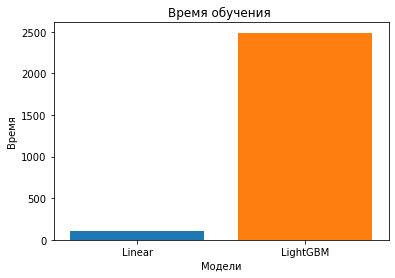

Wall time: 43min 20s


In [18]:
%%time
models = learn_model(models, features_train, features_test, target_train, target_test)

In [107]:
data.columns

Index(['is_in_club', 'rto', 'rto_Крупы и зерновые', 'rto_Мясная гастрономия',
       'rto_Овощи - Фрукты', 'rto_Птица и изделия из птицы',
       'rto_Рыба и рыбные изделия', 'rto_Сыры', 'rto_std',
       'mean_rto_Крупы и зерновые', 'mean_rto_Мясная гастрономия',
       'mean_rto_Овощи - Фрукты', 'mean_rto_Сыры',
       'mean_rto_Рыба и рыбные изделия', 'mean_rto_Птица и изделия из птицы',
       'mean_rto'],
      dtype='object')

In [ ]:
models

In [46]:
model = LGBMClassifier(random_state=666, max_depth=9, learning_rate=0.1, n_estimators=476)
model.fit(features_train, target_train)

predictions = model.predict(features_test)

Text(0, 0.5, 'Mean decrease in impurity')

<Figure size 720x360 with 0 Axes>

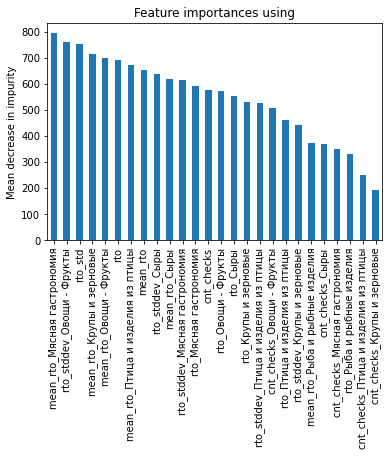

In [47]:
importances = model.feature_importances_

feature_importances = pd.Series(importances, index=features_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using")
ax.set_ylabel("Mean decrease in impurity")


In [ ]:
features_test.columns